In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsbombpy import sb
from matplotlib.lines import Line2D
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Fetching the 2022 World Cup events
events = sb.competition_events(country = 'International', division = 'FIFA World Cup', season = '2022')

In [3]:
# Filtering for shots only
shots = events[events['type'] == 'Shot'].copy()

In [4]:
# Types of shots
shots['shot_type'].value_counts()

Open Play    1382
Penalty        64
Free Kick      46
Corner          2
Name: shot_type, dtype: int64

In [5]:
# Extracting X and Y coordinates from the location list [x, y]
shots['x'] = shots['location'].str[0]
shots['y'] = shots['location'].str[1]

shots['goal'] = (shots['shot_outcome'] == 'Goal').astype(int)

In [15]:
shots = shots[shots['shot_type'] != 'Penalty'] # Removing Penalties because it is shooting from a single point


shots['is_corner'] = shots['play_pattern'].str.contains('Corner', case=False, na=False)
shots['is_free_kick'] = shots['play_pattern'].str.contains('Free Kick', case=False, na=False)
shots['is_header'] = shots['shot_body_part'] == 'Head' # helps the model understand why a close shot might have a lower xG if it was a header
shots['is_volley'] = shots['shot_technique'] == 'Volley' # For volleys/ first time shots - harder to execute 
shots['is_one_on_one'] = shots['shot_one_on_one'].fillna(False) # Big chance indicator, the shooter is 1v1 the goalkeeper

corner_goals = shots[(shots['is_corner'] == True) & (shots['goal'] == 1)]
print(f"Number of corner goals found: {len(corner_goals)}")

Number of corner goals found: 17


In [7]:
def build_features(df):
    
    # Calculating distance to the center of the goal (120, 40)
    df['dist_center'] = np.sqrt((120 - shots['x'])**2 + (40 - shots['y'])**2)
    # Calculating distances to the two posts (120, 36) and (120, 44)
    df['dist_left'] = np.sqrt((120 - df['x'])**2 + (36 - df['y'])**2)
    df['dist_right'] = np.sqrt((120 - df['x'])**2 + (44 - df['y'])**2)

    
    # Using the law of Cosines to find the angle at the shooter's position
    # a = 8 yards (width of the goal), b = dist_left, c = dist_right
    a = 8
    # Numerical stability: Clip values to [-1, 1] for arccos
    cos_val = (df['dist_left']**2 + df['dist_right']**2 - a**2) / (2 * df['dist_left'] * df['dist_right'])
    df['angle_deg'] = np.degrees(np.arccos(np.clip(cos_val, -1, 1)))
    
    return df

# Applying the calculation
shots = build_features(shots)

#### Plotting the distribution of shots

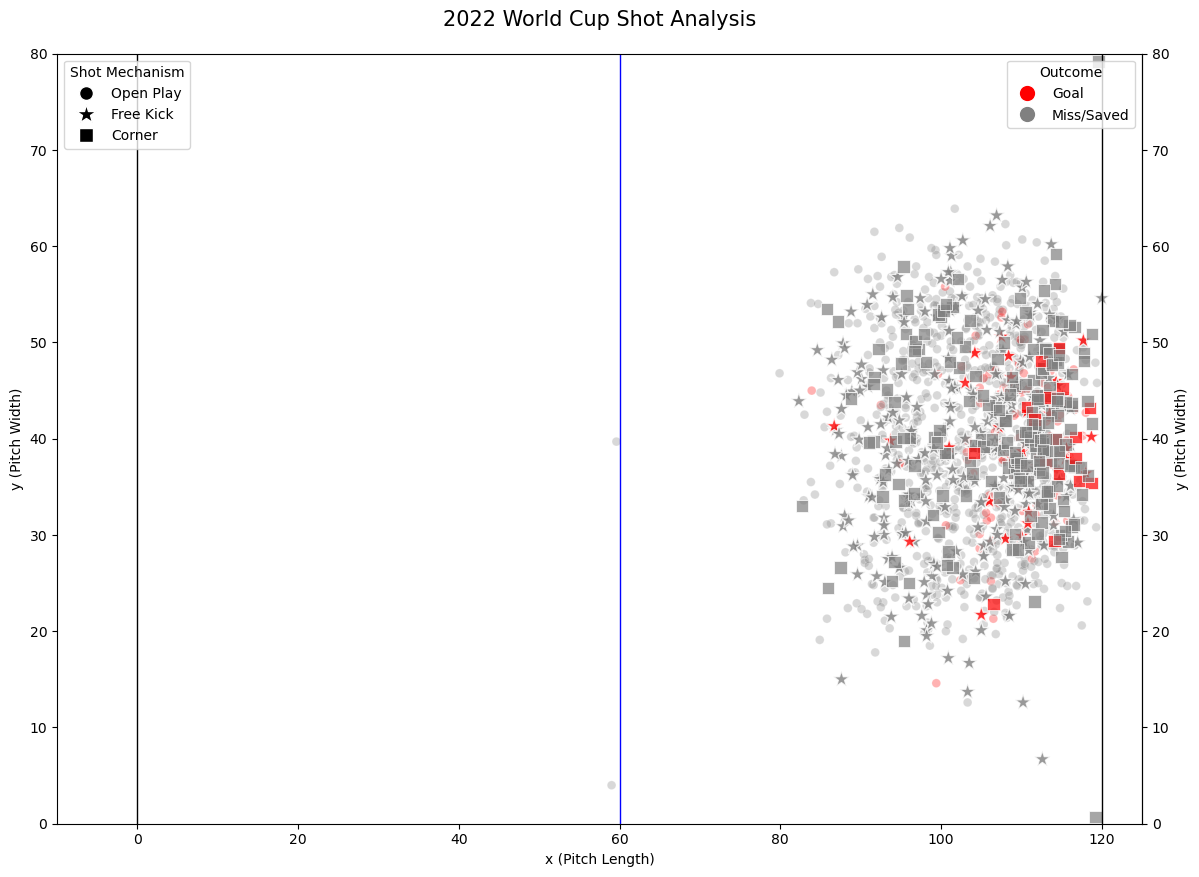

In [8]:
def plot_split_legend_shot_map(df):
    """
     Function to plot the shots made, categorising them into open play, free kicks, corners 
     and indicating successfull goals and missed/saved shots.

    """
    
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # 1. Defining the Groups
    free_kicks = df[df['is_free_kick'] == True]
    corners = df[df['is_corner'] == True]
    open_play = df[(df['is_free_kick'] == False) & (df['is_corner'] == False)]

    # 2. Plotting 
    # Open Play - Circles
    sns.scatterplot(data=open_play, x='x', y='y', hue='goal', 
                    palette={True: 'red', False: 'gray'}, alpha=0.3, marker='o', s=40, legend=False)
    # Free Kicks - Stars
    sns.scatterplot(data=free_kicks, x='x', y='y', hue='goal', 
                    palette={True: 'red', False: 'gray'}, alpha=0.8, marker='*', s=150, legend=False)
    # Corners - Squares
    sns.scatterplot(data=corners, x='x', y='y', hue='goal', 
                    palette={True: 'red', False: 'gray'}, alpha=0.7, marker='s', s=80, legend=False)

    # 3. Legend 1: Shot Type (Shapes)
    shape_elements = [
        Line2D([0], [0], marker='o', color='w', label='Open Play', markerfacecolor='black', markersize=10),
        Line2D([0], [0], marker='*', color='w', label='Free Kick', markerfacecolor='black', markersize=15),
        Line2D([0], [0], marker='s', color='w', label='Corner', markerfacecolor='black', markersize=10)
    ]
    legend1 = ax.legend(handles=shape_elements, loc='upper left', title="Shot Mechanism", frameon=True)
    ax.add_artist(legend1) 

    # 4. Legend 2: Outcome (Colors)
    color_elements = [
        Line2D([0], [0], marker='o', color='w', label='Goal', markerfacecolor='red', markersize=12),
        Line2D([0], [0], marker='o', color='w', label='Miss/Saved', markerfacecolor='gray', markersize=12)
    ]
    ax.legend(handles=color_elements, loc='upper right', title="Outcome", frameon=True)

    # Pitch Aesthetics
    plt.title("2022 World Cup Shot Analysis", fontsize=15, pad=20)
    plt.xlim(-10, 125)
    plt.ylim(0, 80)   
    
    sec_ax = ax.secondary_yaxis('right')
    sec_ax.set_ylabel('y (Pitch Width)')
    ax.set_xlabel('x (Pitch Length)')
    ax.set_ylabel('y (Pitch Width)')
    
    plt.axvline(120, color='black', lw=1)
    plt.axvline(60, color='blue', lw=1) # Halfway line
    plt.axvline(0, color='black', lw=1)
    plt.show()

plot_split_legend_shot_map(shots)

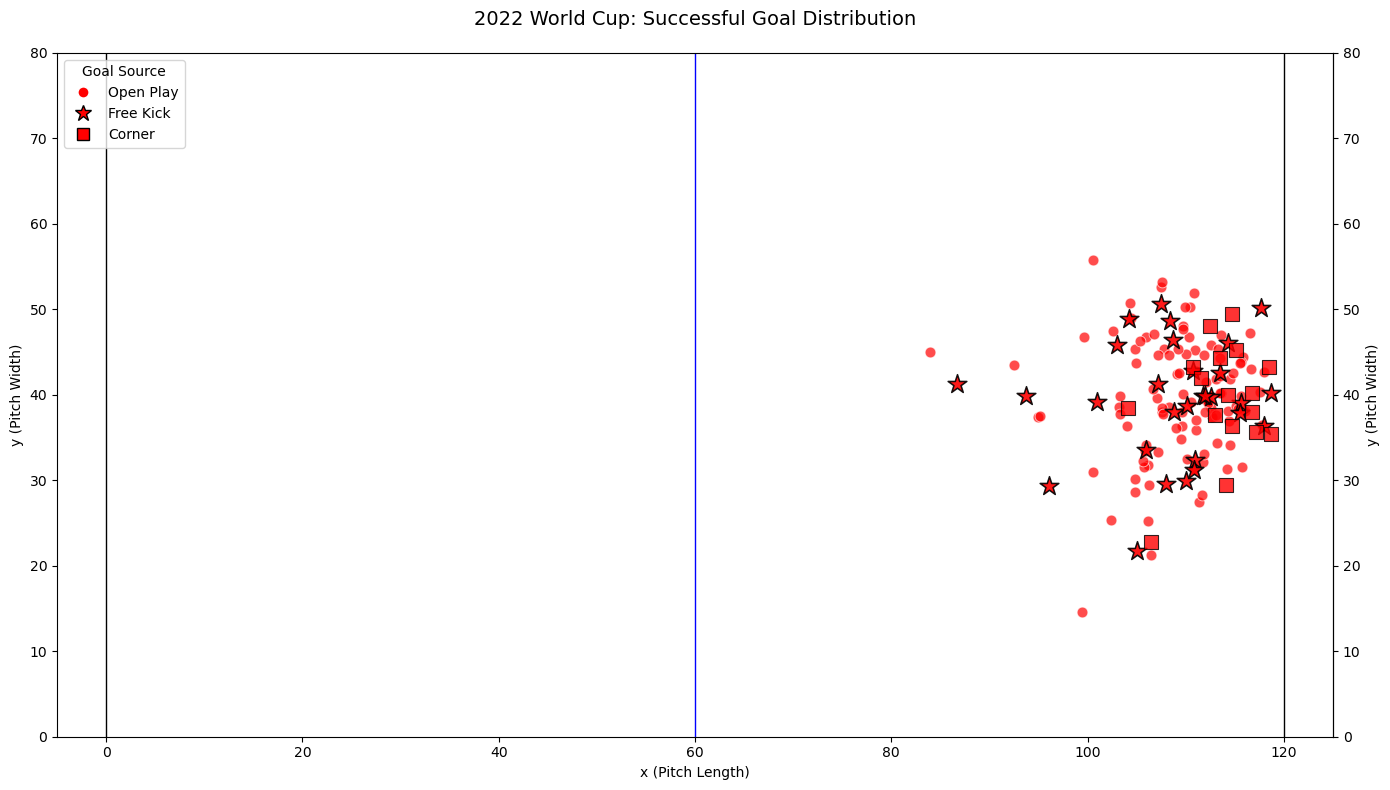

In [9]:
def plot_goals_only_map(df):
    
    """
     Function to plot only the successful goals, categorising them into open play, free kicks, corners.

    """
    
    # 1. Filter for Goals only
    goals_df = df[df['goal'] == 1].copy()
    
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # 2. Define Goal-only Groups
    fk_goals = goals_df[goals_df['is_free_kick'] == True]
    corner_goals = goals_df[goals_df['is_corner'] == True]
    open_goals = goals_df[(goals_df['is_free_kick'] == False) & (goals_df['is_corner'] == False)]

    # 3. Plotting with unique markers (All Red)
    sns.scatterplot(data=open_goals, x='x', y='y', color='red', alpha=0.7, 
                    marker='o', s=60, label='Open Play Goal', ax=ax)
    sns.scatterplot(data=fk_goals, x='x', y='y', color='red', alpha=0.9, 
                    marker='*', s=200, edgecolor='black', label='Free Kick Goal', ax=ax)
    sns.scatterplot(data=corner_goals, x='x', y='y', color='red', alpha=0.8, 
                    marker='s', s=100, edgecolor='black', label='Corner Goal', ax=ax)

    # 4. Secondary Y-Axis
    sec_ax = ax.secondary_yaxis('right')
    sec_ax.set_ylabel('y (Pitch Width)')
    ax.set_xlabel('x (Pitch Length)')
    ax.set_ylabel('y (Pitch Width)')

    # 5. Simplified Legend for Shapes (since color is now constant)
    shape_elements = [
        Line2D([0], [0], marker='o', color='w', label='Open Play', markerfacecolor='red', markersize=8),
        Line2D([0], [0], marker='*', color='w', label='Free Kick', markerfacecolor='red', markersize=12, markeredgecolor='black'),
        Line2D([0], [0], marker='s', color='w', label='Corner', markerfacecolor='red', markersize=8, markeredgecolor='black')
    ]
    ax.legend(handles=shape_elements, loc='upper left', title="Goal Source", frameon=True)

    # Pitch Aesthetics
    plt.title("2022 World Cup: Successful Goal Distribution", fontsize=14, pad=20)
    plt.xlim(-5, 125) 
    plt.ylim(0, 80)  
    plt.axvline(120, color='black', lw=1) # Goal Line
    plt.axvline(60, color='blue', lw=1)
    plt.axvline(0, color='black', lw=1)
    
    plt.tight_layout()
    plt.show()

plot_goals_only_map(shots)

**Finding**  
This map shows exactly where the "danger zone" is. By zooming into the final third, we can see that most goals (red dots) happen right in the middle of the 18-yard box. By refining our filters, we successfully identified 17 goals originating from corner play patterns (shown as red squares). While corners have a low overall conversion rate, they are almost exclusively "high-quality" chances located within the 6-yard box or near the penalty spot. Separating these from open-play goals allows us to see how tactical setups at set-pieces create specific scoring clusters that differ from fluid play.

### Density Plots

##### Density of Shots by Distance to Goal

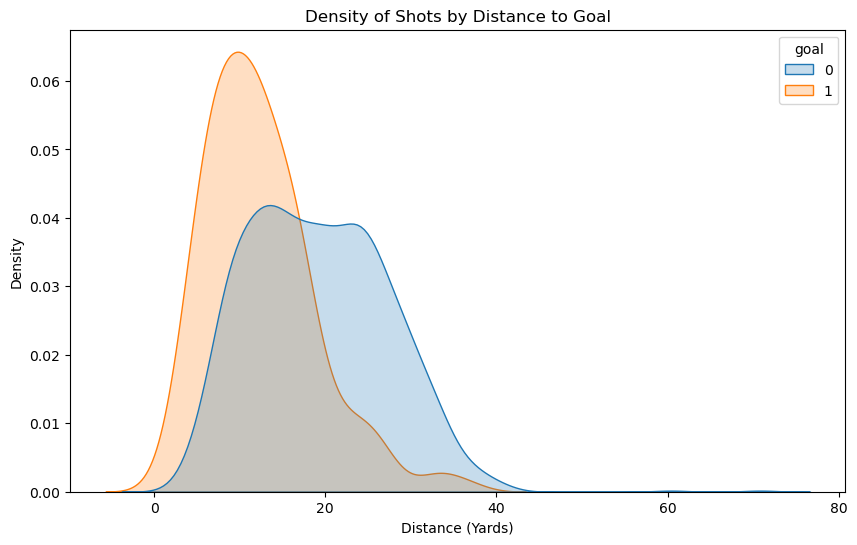

In [10]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=shots, x='dist_center', hue='goal', fill=True, common_norm=False)
plt.title('Density of Shots by Distance to Goal')
plt.xlabel('Distance (Yards)')
plt.ylabel('Density')
plt.show()

**Finding**  
This graph proves that being closer to the goal matters, but it is not the whole story. While the orange "Goal" curve is much further to the left (closer to 0 yards), there is a big overlap with the blue "Miss" curve between 15 and 25 yards. This tells us that just knowing the distance isn't enough to predict a goal; we need more context.

##### Density of Shots with respect to Angles

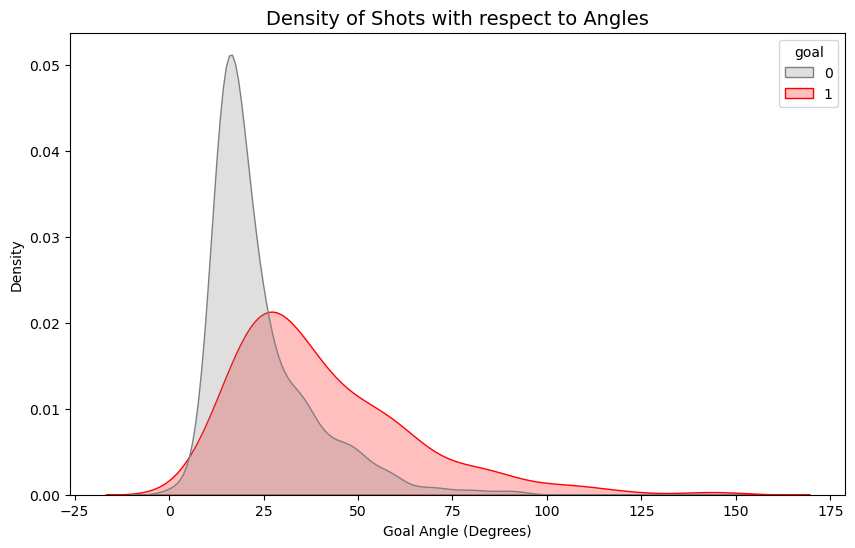

In [11]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=shots, x='angle_deg', hue='goal', fill=True, common_norm=False, palette={1: 'red', 0: 'gray'})
plt.title('Density of Shots with respect to Angles', fontsize=14)
plt.xlabel('Goal Angle (Degrees)')
plt.ylabel('Density')
plt.show()

**Finding**  
When we look at the angle of the shot, the separation between goals and misses is much clearer than it was with distance. Almost all misses happen at tight angles (under $25^{\circ}$), whereas goals have a much wider spread. This confirms that having a "clear view" of the goal mouth is one of the biggest factors in scoring.

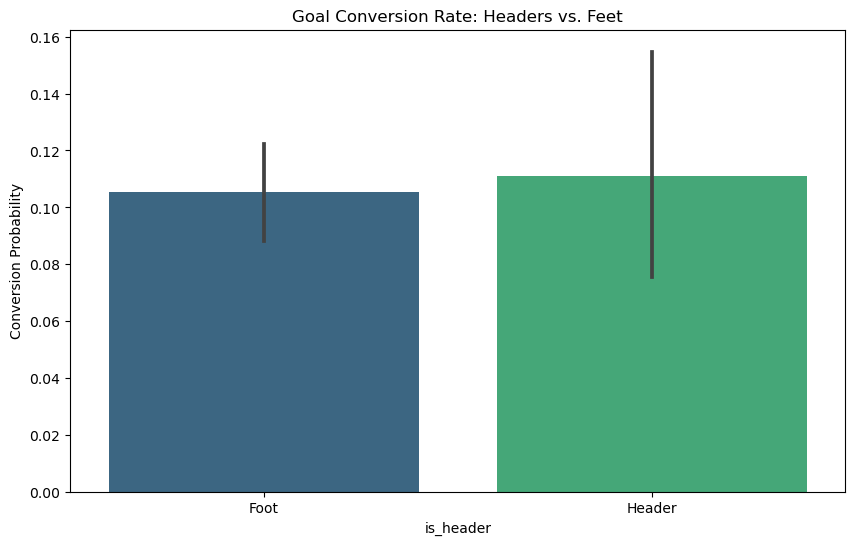

In [16]:
plt.figure(figsize=(10, 6))
sns.barplot(data=shots, x='is_header', y='goal', palette='viridis')
plt.title('Goal Conversion Rate: Headers vs. Feet')
plt.ylabel('Conversion Probability')
plt.xticks([0, 1], ['Foot', 'Header'])
plt.show()

**Finding**  
At first glance, the bar chart shows that headers have a higher conversion probability (11%) compared to shots with the foot (10.5%). This is a classic example of selection bias in football data: players almost never attempt headers from 30 yards out. Headers are highly localized near the goal, which inflates their raw success rate. In our model, is_header will act as a "difficulty multiplier" that helps the model understand that a header from 10 yards is actually much harder to score than a foot-shot from the same spot.

#### Imbalance in the dataset

In [12]:
imbalance = shots['goal'].value_counts(normalize=True)
print(f"Goal Conversion Rate: {imbalance[1]*100:.2f}%")

Goal Conversion Rate: 10.63%


- Since the Goal Conversion Rate is 10.63%, we cannot use **Accuracy** to measure the model's performance. Because the model guessing "no goal" for every shot still makes it 89.37% accurate which will be completely useless in this scenario. 
- To understand the performance of the model better, we must use **AUC-ROC** to measure how well the model separates the "Big Chances" from the long shots, and the **Brier Score** to ensure the 10.6% probability is well-calibrated.

### Feature Correlation

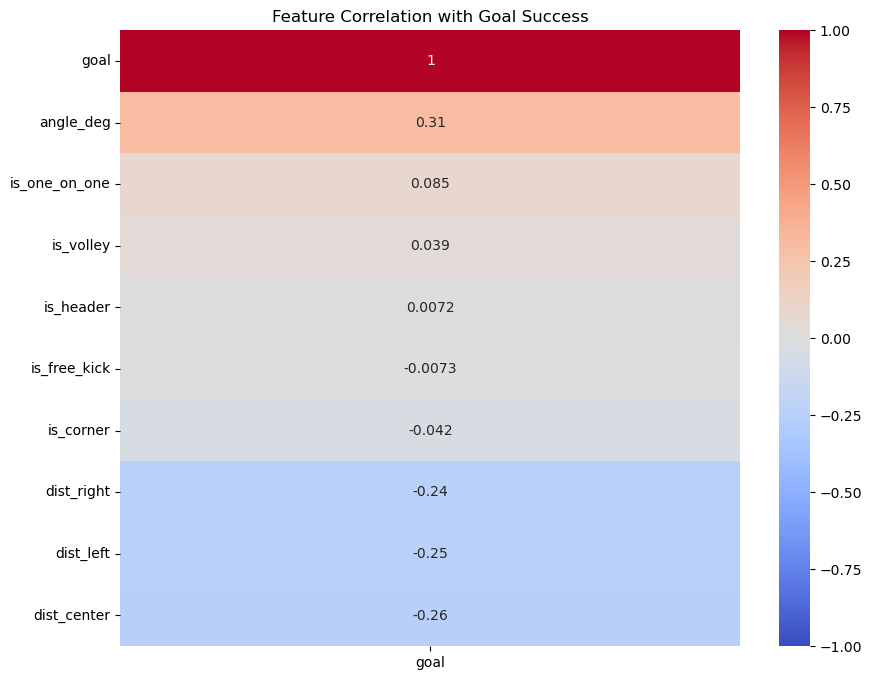

In [17]:
# Selecting the features 
features = ['dist_center', 'dist_left', 'dist_right', 'angle_deg', 'is_free_kick', 'is_corner', 'is_header','is_volley','is_one_on_one','goal']
corr_matrix = shots[features].corr()

# Plotting the Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix[['goal']].sort_values(by='goal', ascending=False), 
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Feature Correlation with Goal Success')
plt.show()

**Finding**  
This heatmap gives us the numbers to back up our charts. The "Goal Angle" has the strongest connection to scoring (0.31). Even though 0.31 might sound low, in a chaotic game like football, it’s a very strong signal. It shows that as the angle opens up, the chance of a goal goes up. We will use XGBoost next to find the non-linear patterns that this simple correlation might miss.

### Hypotheses Testing to establish the importance of Angle as a feature

In [14]:
from scipy.stats import mannwhitneyu

goals_angles = shots[shots['goal'] == 1]['angle_deg']
misses_angles = shots[shots['goal'] == 0]['angle_deg']

stat, p_value = mannwhitneyu(goals_angles, misses_angles, alternative='greater')

print(f"Mann-Whitney U Statistic: {stat}")
print(f"P-value: {p_value:.4e}")

if p_value < 0.05:
    print("✅ Reject Null Hypothesis: Goal Angle is statistically significant!")
else:
    print("❌ Fail to Reject Null Hypothesis.")

Mann-Whitney U Statistic: 146963.5
P-value: 2.0019e-25
✅ Reject Null Hypothesis: Goal Angle is statistically significant!


**Finding**
I ran this test to make sure our findings weren't just a fluke. Since our angle data doesn't follow a normal "bell curve," this test is the best way to compare goals vs. misses.  
**The Result**: The p-value is basically zero ($2.00 \times 10^{-25}$), which is a massive "green light".  
**What it means**: It proves that the difference in angles between goals and misses is 100% real and statistically significant. We can safely move forward with "Angle" as our main feature.